
H3 The more a learner improves during the collaborative activity, the better are the learning outcomes.

* H3.1 The more the learner improves his/her submissions, the better are the learning outcomes.
* H3.2 The more the learner improves his/her suggestions, the better are the learning  outcomes.
* H3.3 The more the learner improves his/her (dis)agreements, the better are the learning outcomes.

How does error difference (collab activities) correlate with learning gain (tests)?

In [1]:
import math
import copy
import pickle

import pathlib as pl
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter, AutoMinorLocator
import seaborn as sns
import numpy as np

from scipy.stats import wilcoxon, shapiro, spearmanr, pearsonr
from effsize.effsize import two_group_difference

from utils import plot_comparison, pick_colors

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
# Visuals in paper theme, with larger font and thicker lines.
sns.set_theme()
sns.set_context('paper', font_scale=1.5, rc={"lines.linewidth": 2.5})

### Define paths.

In [4]:
# Inputs.
learning_file = pl.Path(
    '../processed_data/justhink21_learning_outcomes.csv')
performance_file = pl.Path(
    '../processed_data/justhink21_task_performance.csv')

# transitions_pickle_file = pl.Path(
#     '../processed_data/justhink21_transitions.pickle')
# submissions_pickle_file = pl.Path(
#     '../processed_data/justhink21_submissions.pickle')

# Outputs.
figs_dir = pl.Path('../figures')
perf_vs_learning_fig_file = figs_dir.joinpath('performance_vs_learning.pdf')
change_fig_file = figs_dir.joinpath('change_performance.pdf')

### Load learning outcomes table.

In [5]:
learning_df = pd.read_csv(learning_file, index_col=0)
learning_df

,pretest_feasible,posttest_feasible,pretest_optimal,posttest_optimal,pretest_error,posttest_error,gain_feasible,gain_optimal,learning_gain
participant,,,,,,,,,
1,1.0,1.0,0.4,0.8,0.169524,0.013333,0.0,0.666667,0.156190
2,0.8,1.0,0.0,0.8,0.310476,0.009524,1.0,0.800000,0.300952
3,1.0,1.0,0.2,1.0,0.040635,0.000000,0.0,1.000000,0.040635
4,0.8,1.0,0.0,0.0,0.389841,0.355556,1.0,NaN,0.034286
5,1.0,0.8,0.0,0.0,0.300317,0.166984,-0.2,NaN,0.133333
6,1.0,0.8,0.0,0.0,0.309841,0.149841,-0.2,NaN,0.160000
7,0.4,0.0,0.2,0.0,0.040000,NaN,-1.0,-1.000000,NaN
8,1.0,1.0,0.0,0.0,0.925714,0.103492,0.0,NaN,0.822222
9,1.0,1.0,0.8,0.8,0.013333,0.009524,0.0,0.000000,0.003810


### Load the task performance table.

In [6]:
performance_df = pd.read_csv(performance_file, index_col=0)
performance_df

,attempt_no_1,attempt_no_2,error_1,error_2,is_mst_1,is_mst_2,is_spanning_1,is_spanning_2,performance_gain
participant,,,,,,,,,
1,2.0,3.0,0.318182,0.000000,False,True,True,True,0.318182
2,1.0,6.0,0.000000,0.000000,True,True,True,True,-0.000000
3,3.0,2.0,0.000000,0.057143,True,False,True,True,-0.057143
4,2.0,3.0,0.318182,0.000000,False,True,True,True,0.318182
5,3.0,1.0,0.318182,0.000000,False,True,True,True,0.318182
6,1.0,1.0,0.772727,0.542857,False,False,True,True,0.229870
7,2.0,NaN,0.000000,NaN,True,NaN,True,NaN,NaN
8,3.0,2.0,0.045455,0.000000,False,True,True,True,0.045455
9,1.0,1.0,0.000000,0.000000,True,True,True,True,-0.000000


### Combine to a results summary table.

In [7]:
results_df = pd.concat([performance_df, learning_df], axis=1)
results_df

,attempt_no_1,attempt_no_2,error_1,error_2,is_mst_1,is_mst_2,is_spanning_1,is_spanning_2,performance_gain,pretest_feasible,posttest_feasible,pretest_optimal,posttest_optimal,pretest_error,posttest_error,gain_feasible,gain_optimal,learning_gain
participant,,,,,,,,,,,,,,,,,,
1,2.0,3.0,0.318182,0.000000,False,True,True,True,0.318182,1.0,1.0,0.4,0.8,0.169524,0.013333,0.0,0.666667,0.156190
2,1.0,6.0,0.000000,0.000000,True,True,True,True,-0.000000,0.8,1.0,0.0,0.8,0.310476,0.009524,1.0,0.800000,0.300952
3,3.0,2.0,0.000000,0.057143,True,False,True,True,-0.057143,1.0,1.0,0.2,1.0,0.040635,0.000000,0.0,1.000000,0.040635
4,2.0,3.0,0.318182,0.000000,False,True,True,True,0.318182,0.8,1.0,0.0,0.0,0.389841,0.355556,1.0,NaN,0.034286
5,3.0,1.0,0.318182,0.000000,False,True,True,True,0.318182,1.0,0.8,0.0,0.0,0.300317,0.166984,-0.2,NaN,0.133333
6,1.0,1.0,0.772727,0.542857,False,False,True,True,0.229870,1.0,0.8,0.0,0.0,0.309841,0.149841,-0.2,NaN,0.160000
7,2.0,NaN,0.000000,NaN,True,NaN,True,NaN,NaN,0.4,0.0,0.2,0.0,0.040000,NaN,-1.0,-1.000000,NaN
8,3.0,2.0,0.045455,0.000000,False,True,True,True,0.045455,1.0,1.0,0.0,0.0,0.925714,0.103492,0.0,NaN,0.822222
9,1.0,1.0,0.000000,0.000000,True,True,True,True,-0.000000,1.0,1.0,0.8,0.8,0.013333,0.009524,0.0,0.000000,0.003810


In [8]:
# with submissions_pickle_file.open('rb') as handle:
#     submissions = pickle.load(handle)

# # Example:
# submissions_df = submissions['best'] #.reset_index(drop=True)
# submissions_df.head()

In [9]:
# import pathlib as pl
# import pickle
# import pandas as pd
# import copy
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# import math
# #import wilcoxon signed-rank
# from scipy.stats import wilcoxon, shapiro, ttest_rel, stats
# #import cliffs delta
# from effsize.effsize import two_group_difference

In [10]:
# processed_tables_pickle_file = pl.Path(
#     '../processed_data/processed_tables.pickle')
# collab_best_pickle_file = pl.Path(
#     '../processed_data/collab_best_df.pickle')
# learning_df_pickle_file = pl.Path(
#     '../processed_data/learning_df.pickle')
# cdf_human_pickle_file = pl.Path(
#     '../processed_data/cdf_human.pickle')

In [11]:
# Load pickled data.
# with processed_tables_pickle_file.open('rb') as handle:
#     processed_tables = pickle.load(handle)

# with collab_best_pickle_file.open('rb') as handle:
#     collab_best = pickle.load(handle)

# with learning_df_pickle_file.open('rb') as handle:
#     learning_df = pickle.load(handle)
    
# with cdf_human_pickle_file.open('rb') as handle:
#     cdf_human = pickle.load(handle)

In [12]:
# processed_tables.keys()
# pd.options.display.max_columns = None
# df = processed_tables[10]
# df = df.loc[df['header.frame_id'] == 'collab-activity-2']
# df

### Compute the change in performance in the collaborative activities.

In [13]:
# submissions_df

In [14]:
# submissions_df

In [15]:
# best_df = df[df.is_best]
# activities = ['collaboration-1', 'collaboration-2']

### Compute improvement throughout collaborative activities.

Calculating error difference from collab activities.

In [16]:
# collab_best.sort_values(by=['student'], inplace=True)
# collab_best

In [17]:
# collab_a = collab_best.loc[collab_best['activity'] == 'collab-activity']
# collab_b = collab_best.loc[collab_best['activity'] == 'collab-activity-2']

# students = list(collab_a['student'])

# error_diff = {}
# for i in list(collab_a['student']):
#     i = int(i)
#     diff = float(collab_b.loc[collab_b['student'] == i]['error']) - \
#         float(collab_a.loc[collab_a['student'] == i]['error'])
#     error_diff[int(i)] = diff

# error_diff

In [18]:
# ## Check H3.1

# H3.1. The more the learner improves his/her submissions, the better are the learning outcomes.
# - How does error difference (collab activities) correlate with learning gain (tests)?

## Processing

In [19]:
# TODO

## Hypothesis Testing

### H3.1: The more the learner improves his/her submissions, the better are the learning outcomes.

#### Check performance gain vs. learning gain.

In [20]:
cols = ['performance_gain', 'learning_gain']
df = results_df.dropna(subset=cols)
pearsonr(list(df[cols[0]]), list(df[cols[1]])), len(df)

((-0.21891642993094784, 0.6024574444863945), 8)

### H3.2: The more the learner improves his/her suggestions, the better are the learning  outcomes.

In [21]:
# TODO

### H3.3: The more the learner improves his/her (dis)agreements, the better are the learning outcomes.

In [22]:
# TODO

## Visualizations

### Visualize performance vs. learning gains.

Graph is exported to ../figures/performance_vs_learning.pdf


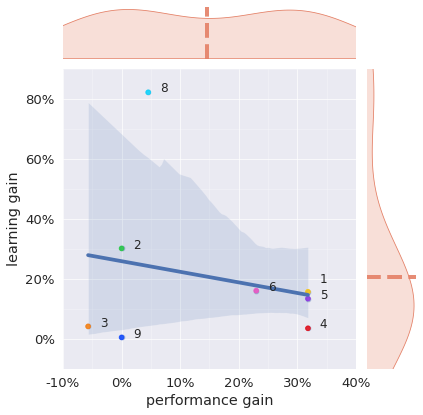

In [23]:
def plot_performance_vs_learning(
        col_x, col_y, df, colors, scatter_alpha=.8):

    def colored_scatter(x, y, c=None, label=None):
        def scatter(*args, **kwargs):
            args = (x, y)
            if c is not None:
                kwargs['c'] = c
            kwargs['alpha'] = scatter_alpha
            kwargs['label'] = label
            plt.scatter(*args, **kwargs)

        return scatter

    df = df.copy()
    prev_x_counts = None
    prev_y_counts = None

    step = 10
    g = sns.JointGrid(
        x=col_x, y=col_y, xlim=[-0.1, 0.4], ylim=[-0.1, 0.9], data=df)

    sns.despine(ax=g.ax_joint, left=True)

    # Plot versus.
    sns.regplot(
        x=col_x, y=col_y, data=df, ax=g.ax_joint,
        scatter_kws={'alpha': 0.3})

    g.plot_joint(colored_scatter(df[col_x], df[col_y], colors))

    # Plot performance distribution.
    # Draw a KDE plot.
    color = '#e48066'
    sns.kdeplot(
        df[col_x].values, ax=g.ax_marg_x, color=color, shade=True)
    # Draw the mean line segments.
    m = np.mean(df[col_x])
    g.ax_marg_x.axvline(
        m, ls='--', lw=4, c=color, alpha=0.9)

    # Plot learning distribution.
    # Draw a KDE plot.
    sns.kdeplot(
        y=df[col_y].values, ax=g.ax_marg_y, color=color, shade=True,
    )
    # Draw the mean line segments.
    m = np.mean(df[col_y])
    g.ax_marg_y.axhline(
        m, ls='--', lw=4, c=color, alpha=0.9)

    # Adjust the ticks.
    g.ax_joint.xaxis.set_minor_locator(AutoMinorLocator(n=2))
    g.ax_joint.yaxis.set_minor_locator(AutoMinorLocator(n=2))

    # Adjust the grid.
    plt.grid(alpha=0.85)
    plt.grid(which='minor', alpha=0.3)

    # Adjust the background colors.
    g.ax_marg_x.set_facecolor('white')
    g.ax_marg_y.set_facecolor('white')

    # Add annotations one by one with a loop.
    takens = dict()
    for i, row in df.iterrows():
        x, y = row[col_x], row[col_y]
        if np.isnan(x) or np.isnan(y):
            continue
        offset = (0.02, 0) if i != 1 else (0.02, 0.03)
        g.ax_joint.text(
            x + offset[0], y + offset[1], str(i), fontsize='small')

    g.ax_joint.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    g.ax_joint.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    # Set axis labels.
    g.ax_joint.set_xlabel('performance gain')
    g.ax_joint.set_ylabel('learning gain')

    return g


perf_col = 'performance_gain'
learn_col = 'learning_gain'
df = results_df

colors = pick_colors()
colors = [colors[p] for p in df.index]
g = plot_performance_vs_learning(perf_col, learn_col, results_df, colors)

# Export as vector graphics - pdf.
plt.savefig(perf_vs_learning_fig_file, bbox_inches='tight')
print('Graph is exported to {}'.format(perf_vs_learning_fig_file))

### Visualize performance vs. learning changes.

In [24]:
# from https://stackoverflow.com/a/34018322
def add_arrow(line, position=None, direction='right', size=24, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate(
        '',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )

Graph is exported to ../figures/change_performance.pdf


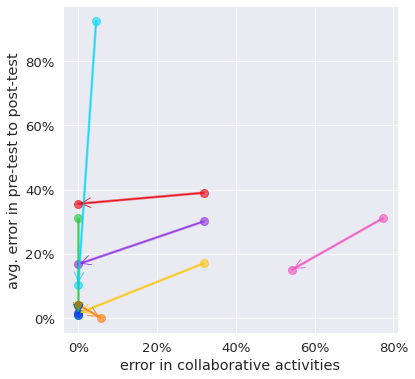

In [25]:
perf_cols = ['error_1', 'error_2']
learn_cols = ['pretest_error', 'posttest_error']
df = results_df
df.columns

colors = pick_colors()

fig, ax = plt.subplots(1, figsize=(6, 6))
for i, row in df.iterrows():
    xs = row[perf_cols[0]], row[perf_cols[1]]
    ys = row[learn_cols[0]], row[learn_cols[1]]

    line = ax.plot(
        xs, ys, marker='o', ms=8,
        color=colors[i], label=i, alpha=.6)[0]
    add_arrow(line)

    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    ax.set_xlabel('error in collaborative activities')
    ax.set_ylabel('avg. error in pre-test to post-test')
    
plt.savefig(change_fig_file, bbox_inches='tight')
print('Graph is exported to {}'.format(change_fig_file))